In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import tqdm
import os
import gc
import glob
import math
import torch
import utils
from scipy.special import erf
from sklearn.calibration import calibration_curve
from sklearn.metrics import (auc, brier_score_loss, confusion_matrix,
                             mean_absolute_error, mean_squared_error,
                             precision_recall_curve, r2_score, roc_curve,
							 precision_score, recall_score, f1_score,
                             mutual_info_score)
from sklearn.feature_selection import mutual_info_regression, r_regression
from scipy.stats import entropy
import utils

/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/spacepy/time.py:2367: UserWarning: Leapseconds may be out of date. Use spacepy.toolbox.update(leapsecs=True)
  warnings.warn('Leapseconds may be out of date.'


In [2]:
model_type = 'twins'
shap_dir = 'outputs/shap_values'
scaler_dir = 'outputs/scalers'
results_dir = 'outputs/rsd'
VERSION = 'swmag_v6-1'
shap_files = glob.glob(f'{shap_dir}/*{VERSION}*.pkl')
scaler_files = glob.glob(f'{scaler_dir}/*{VERSION}.pkl')
results_files = glob.glob(f'{scaler_dir}/*{VERSION}.feather')
with open('cluster_dict.pkl', 'rb') as f:
	cluster_dict = pickle.load(f)

list_of_oversampled_regions = ['GRL-1', 'GRL-2', 'SVLB', 'JPN-0']

In [3]:
scalers = {}
for cluster in cluster_dict.values():
	for key, region in cluster['regions'].items():
		scalers[key] = {}
		if key in list_of_oversampled_regions:
			if os.path.exists(f'{scaler_dir}/twins_{key}_twins_v_maxpooling_oversampling.pkl'):
				with open(f'{scaler_dir}/twins_{key}_twins_v_maxpooling_oversampling.pkl', 'rb') as f:
					scaler_values = pickle.load(f)
					scalers[key]['twins'] = scaler_values
		else:
			if os.path.exists(f'{scaler_dir}/twins_{key}_twins_v_maxpooling.pkl'):
				with open(f'{scaler_dir}/twins_{key}_twins_v_maxpooling.pkl', 'rb') as f:
					scaler_values = pickle.load(f)
					scalers[key]['twins'] = scaler_values

In [4]:
for cluster in cluster_dict.values():
	for key, region in cluster['regions'].items():
		if key in list_of_oversampled_regions:
			if os.path.exists(f'{shap_dir}/twins_region_{key}_twins_v_maxpooling_oversampling.pkl'):
				with open(f'{shap_dir}/twins_region_{key}_twins_v_maxpooling_oversampling.pkl', 'rb') as f:
					shap_values = pickle.load(f)
					cluster['regions'][key]['twins_shap'] = shap_values
		else:
			if os.path.exists(f'{shap_dir}/twins_region_{key}_twins_v_maxpooling.pkl'):
				with open(f'{shap_dir}/twins_region_{key}_twins_v_maxpooling.pkl', 'rb') as f:
					shap_values = pickle.load(f)
					cluster['regions'][key]['twins_shap'] = shap_values

In [5]:
other_model = 'twins'

for cluster in cluster_dict.values():
	for region in cluster['regions'].values():
		region['mean_lat'] = utils.getting_mean_lat(region['stations'])

# individual_cluster_to_examine = 'canadian_cluster'
twins_mean_shap, twins_std_shap = [], []

def inverse_transform_twins(X, mean, std):
	return X*std + mean

for cluster in cluster_dict.keys():
	for reg, region in cluster_dict[cluster]['regions'].items():
		if f'{other_model}_shap' in region.keys():

			region[f'{other_model}_shap']['swmag_mean_shap'] = np.concatenate([region[f'{other_model}_shap']['shap_values'][i][0][0][:,:,:,:] for i in range(len(region[f'{other_model}_shap']['shap_values']))], axis=0)
			region[f'{other_model}_shap']['swmag_std_shap'] = np.concatenate([region[f'{other_model}_shap']['shap_values'][i][1][0][:,:,:,:] for i in range(len(region[f'{other_model}_shap']['shap_values']))], axis=0)

			region[f'{other_model}_shap']['twins_mean_shap'] = np.concatenate([region[f'{other_model}_shap']['shap_values'][i][0][1][:,:,:,:] for i in range(len(region[f'{other_model}_shap']['shap_values']))], axis=0)
			region[f'{other_model}_shap']['twins_std_shap'] = np.concatenate([region[f'{other_model}_shap']['shap_values'][i][1][1][:,:,:,:] for i in range(len(region[f'{other_model}_shap']['shap_values']))], axis=0)

			for key in region[f'{other_model}_shap'].keys():
				if isinstance(region[f'{other_model}_shap'][key], torch.Tensor):
					region[f'{other_model}_shap'][key] = region[f'{other_model}_shap'][key].numpy()

			# try:
			region[f'{other_model}_shap']['swmag_mean_shap'] = region[f'{other_model}_shap']['swmag_mean_shap'].reshape(region[f'{other_model}_shap']['swmag_mean_shap'].shape[0], region[f'{other_model}_shap']['swmag_mean_shap'].shape[2], region[f'{other_model}_shap']['swmag_mean_shap'].shape[3])
			region[f'{other_model}_shap']['swmag_std_shap'] = region[f'{other_model}_shap']['swmag_std_shap'].reshape(region[f'{other_model}_shap']['swmag_std_shap'].shape[0], region[f'{other_model}_shap']['swmag_std_shap'].shape[2], region[f'{other_model}_shap']['swmag_std_shap'].shape[3])

			region[f'{other_model}_shap']['twins_mean_shap'] = region[f'{other_model}_shap']['twins_mean_shap'].reshape(region[f'{other_model}_shap']['twins_mean_shap'].shape[0], region[f'{other_model}_shap']['twins_mean_shap'].shape[2], region[f'{other_model}_shap']['twins_mean_shap'].shape[3])
			region[f'{other_model}_shap']['twins_std_shap'] = region[f'{other_model}_shap']['twins_std_shap'].reshape(region[f'{other_model}_shap']['twins_std_shap'].shape[0], region[f'{other_model}_shap']['twins_std_shap'].shape[2], region[f'{other_model}_shap']['twins_std_shap'].shape[3])

			region[f'{other_model}_shap']['testing_data'][1] = region[f'{other_model}_shap']['testing_data'][1].reshape(region[f'{other_model}_shap']['testing_data'][1].shape[0], region[f'{other_model}_shap']['testing_data'][1].shape[2], region[f'{other_model}_shap']['testing_data'][1].shape[3])
			
			# unscaling the testing_data
			mu = scalers[reg][other_model]['twins_mean']
			sigma = scalers[reg][other_model]['twins_std']

			region[f'{other_model}_shap']['testing_data'][1] = region[f'{other_model}_shap']['testing_data'][1]*sigma + mu
			
			mean_added = np.sum(np.sum(np.abs(region[f'{other_model}_shap']['swmag_mean_shap']), axis=1),axis=1) + np.sum(np.sum(np.abs(region[f'{other_model}_shap']['twins_mean_shap']), axis=1),axis=1)
			region[f'{other_model}_shap']['twins_mean_shap'] = region[f'{other_model}_shap']['twins_mean_shap']/mean_added[:,None,None]

			std_added = np.sum(np.sum(np.abs(region[f'{other_model}_shap']['swmag_std_shap']), axis=1),axis=1) + np.sum(np.sum(np.abs(region[f'{other_model}_shap']['twins_std_shap']), axis=1),axis=1)
			region[f'{other_model}_shap']['twins_std_shap'] = region[f'{other_model}_shap']['twins_std_shap']/std_added[:,None,None]

			del region[f'{other_model}_shap']['swmag_mean_shap'], region[f'{other_model}_shap']['swmag_std_shap']
			gc.collect()


Loading station NEW....
Loading station T19....
Loading station C10....
Loading station LET....
Loading station T03....
Loading station T43....
Loading station LET....
Loading station T03....
Loading station T43....
Loading station RED....
Loading station C06....
Loading station T43....
Loading station RED....
Loading station C06....
Loading station MEA....
Loading station T36....
Loading station GHB....
Loading station SKT....
Loading station STF....
Loading station ATU....
Loading station SKT....
Loading station STF....
Loading station ATU....
Loading station GDH....
Loading station STF....
Loading station ATU....
Loading station GDH....
Loading station UMQ....
Loading station GHB....
Loading station FHB....
Loading station NAQ....
Loading station RVK....
Loading station LYC....
Loading station DON....
Loading station JCK....
Loading station HAN....
Loading station MEK....
Loading station OUJ....
Loading station NUR....
Loading station MAS....
Loading station NOR....
Loading station 

In [6]:
def mlt_wedge(img_data, mlt_min: int = 18, mlt_max: int = 6, center_x: int = 120, center_y: int = 80):
    """
    This function takes in a temperature ENA image and divides thems into pie slices based on the
    numbers of slices desired. The output of the function is an array of the mean different sections of the
    ENA temperature map generated and the different sections themselves, respectively.
    Parameters:
    -----------
    img_data : ndarray
        Input image data.
    mlt_min : int, optional
        Minimum MLT value. Default is 18.
    mlt_max : int, optional
        Maximum MLT value. Default is 6.
    mlt_span : int, optional
        MLT span. Default is 1.
    angle_steps : int, optional
        Number of angle steps for pie slices. Default is 8.
    center_x : int, optional
        X-coordinate of the center. Default is 120.
    center_y : int, optional
        Y-coordinate of the center. Default is 80.
    Returns:
    --------
    selected_sections : list
        List of selected pie slice sections.
    """
    # get the dimension of the image
    height, width = img_data.shape
    # Create an empty list to store the selected sections
    selected_sections = []
    img_mean = []
    # define the numbers of angles used for the pie slices
    # Create masks for each N-degree section and apply them to the image
    # Create a new blank mask as a NumPy array
    mask = np.zeros((height, width), dtype=np.uint8)
    img_copy = np.copy(img_data)
    # Calculate the coordinates of the sector's bounding box

    start_angle = (mlt_min*15) % 360
    end_angle = (mlt_max*15) % 360

    # print(f'start_angle: {start_angle}, end_angle: {end_angle}')
    # Calculate the coordinates of the sector arc
    for y in range(height):
        for x in range(width):
            # Calculate the polar coordinates of the pixel relative to the image center
            dx = center_x - x
            dy = center_y - y
            pixel_angle = math.degrees(math.atan2(dy, dx))  # Calculate the angle in radians
            if pixel_angle < 0:
                pixel_angle += 360
            # Check if the pixel is within the current 45-degree section
            if mlt_min > mlt_max:
                if start_angle <= pixel_angle < 360 or 0 <= pixel_angle < end_angle:
                    mask[y, x] = 1
            else:
                if start_angle <= pixel_angle < end_angle:
                    mask[y, x] = 1  # Set the pixel to white (255)
    # Apply the mask to the heat map to select the section
    img_copy[mask == 0] = 0
    # Append the selected section to the list
    selected_sections = img_copy
    xx = np.copy(img_copy)
    xx[xx == 0] = np.nan
    # Get the mean of the non zero values of the image
    img_mean.append(np.nanmean(xx))
    # print(f'mean: {np.nanmean(xx)}')
    return img_mean, selected_sections

In [7]:
key = '2012-03-07 01:50:00'
cluster = 'greenland_cluster'
region = 'GRL-0'
cluster = 'canadian_cluster'
region = 'CAN-2'
if region in list_of_oversampled_regions:
	results = pd.read_feather(f'{results_dir}/twins_modeling_region_{region}_version_twins_v_maxpooling_oversampling.feather')
else:
	results = pd.read_feather(f'{results_dir}/twins_modeling_region_{region}_version_twins_v_maxpooling.feather')
mlt_station = utils.loading_supermag(cluster_dict[cluster]['regions'][region]['mlt_station'])

Loading station MEA....


/tmp/ipykernel_86554/2191961429.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mlt = mlt_station[mlt_station.index == cluster_dict[cluster]['regions'][region]['twins_shap']['Date_UTC'].iloc[i][0]]['MLT'].values[0]
/tmp/ipykernel_86554/2191961429.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.suptitle(f"{cluster_dict[cluster]['regions'][region]['twins_shap']['Date_UTC'].iloc[i][0]} - Ground Truth: {cluster_dict[cluster]['regions'][region]['twins_shap']['ytest'][i]} - MLT: {mlt:.2f} - Prediction: {pred_mean:.4f}", fontsize=20)
/tmp/ipykernel_86554/41730398.py:66: RuntimeWarning: Mean of empty slice
  img_

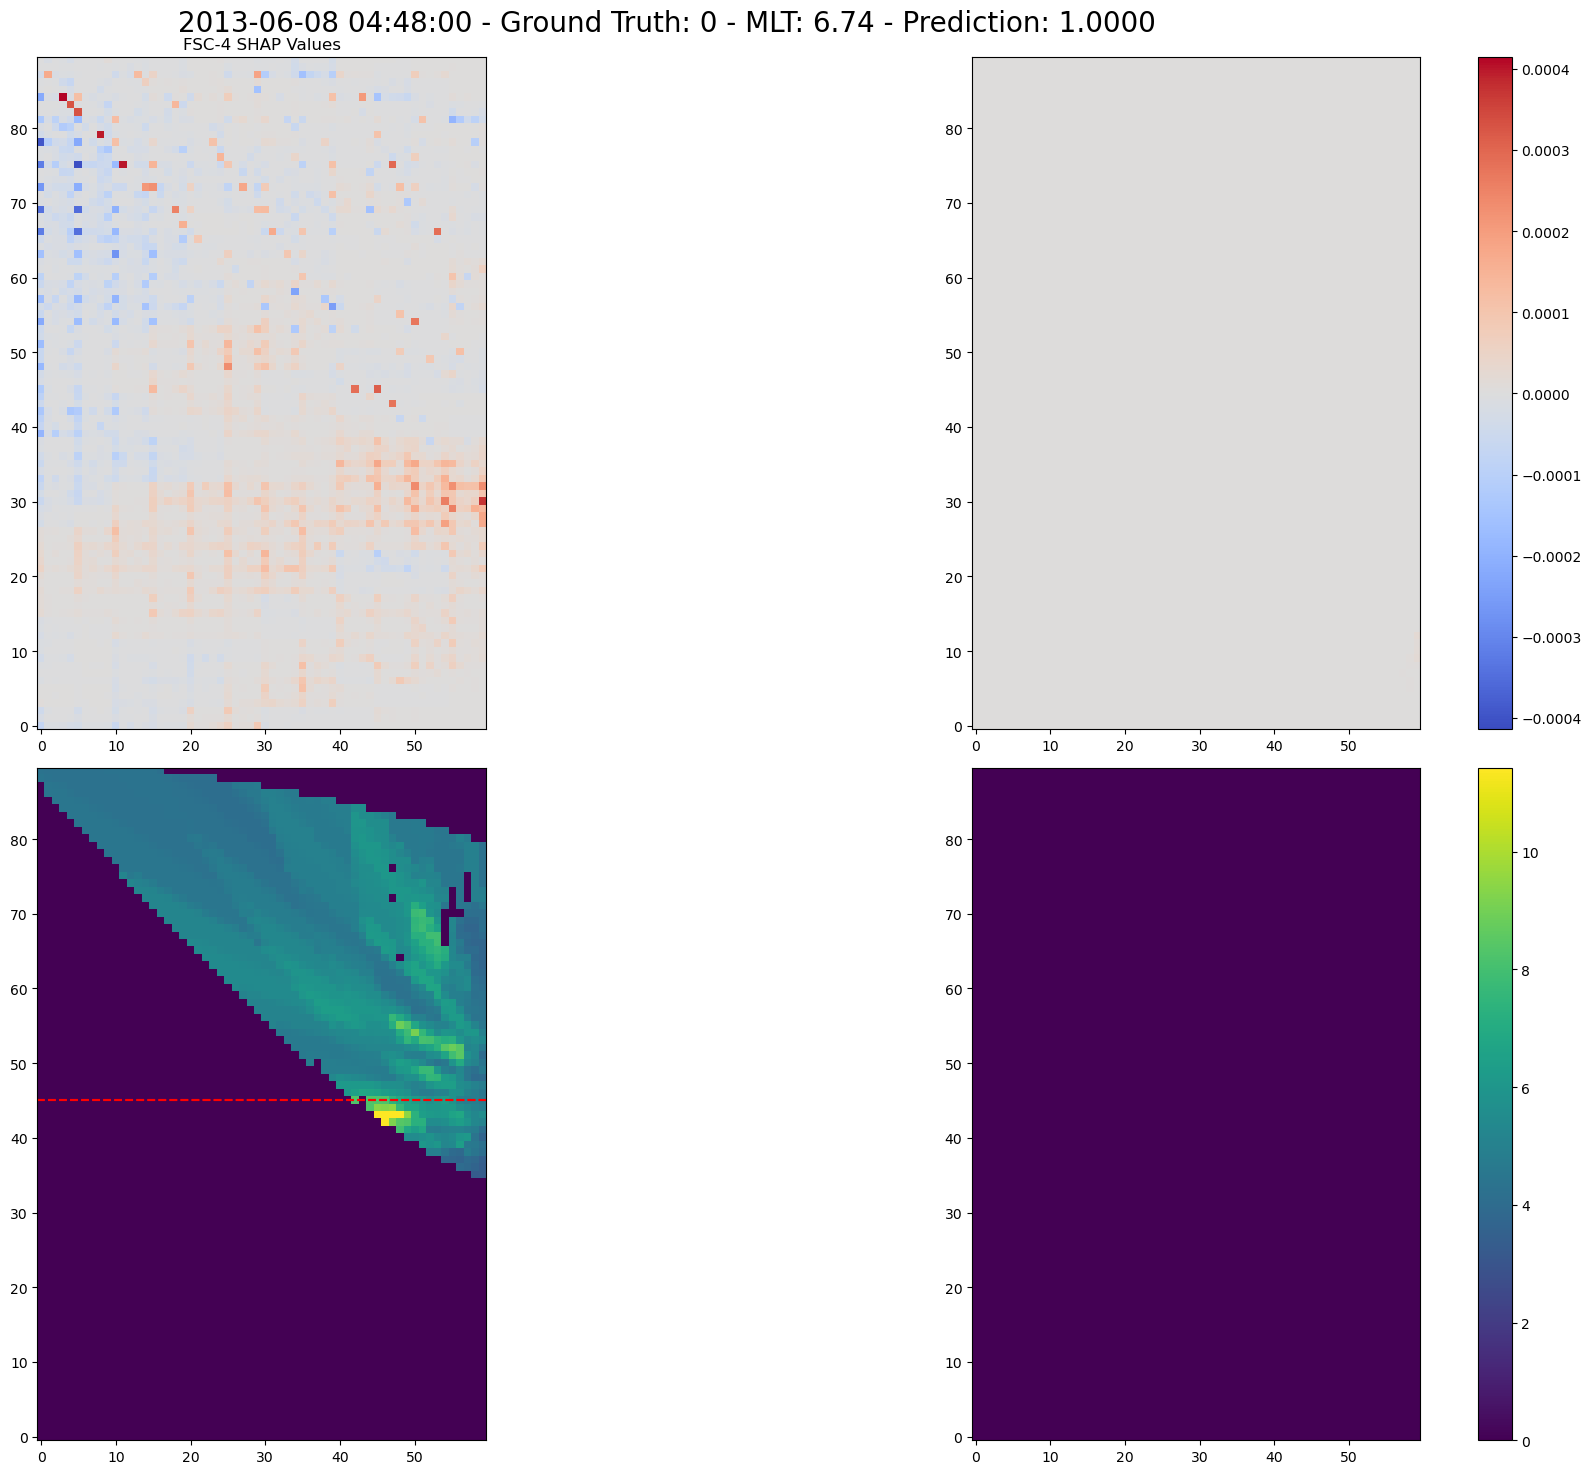

In [11]:
i = 6864
mlt = mlt_station[mlt_station.index == cluster_dict[cluster]['regions'][region]['twins_shap']['Date_UTC'].iloc[i][0]]['MLT'].values[0]
pred_mean = results['predicted_mean'].iloc[i]
mlt_min = mlt-2 if mlt >=2 else 24+mlt-2
mlt_max = mlt+2 if mlt <=22 else mlt-24+2
full_img_mean, full_selected_sections = mlt_wedge(cluster_dict[cluster]['regions'][region]['twins_shap']['twins_mean_shap'][i], mlt_min=mlt_min, mlt_max=mlt_max, center_x=70, center_y=45)
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
plt.suptitle(f"{cluster_dict[cluster]['regions'][region]['twins_shap']['Date_UTC'].iloc[i][0]} - Ground Truth: {cluster_dict[cluster]['regions'][region]['twins_shap']['ytest'][i]} - MLT: {mlt:.2f} - Prediction: {pred_mean:.4f}", fontsize=20)
vmin = np.nanmin(cluster_dict[cluster]['regions'][region]['twins_shap']['twins_mean_shap'][i])
vmax = np.nanmax(cluster_dict[cluster]['regions'][region]['twins_shap']['twins_mean_shap'][i])
limit = np.max([np.abs(vmin), np.abs(vmax)])
ax[0,0].set_title(f'{region} SHAP Values')
im0 = ax[0,0].imshow(cluster_dict[cluster]['regions'][region]['twins_shap']['twins_mean_shap'][i], cmap='coolwarm', vmin=-limit, vmax=limit, origin='lower')
ax[1,0].axhline(y=45, color='r', linestyle='--')
ax[0,1].imshow(full_selected_sections, cmap='coolwarm', vmin=-limit, vmax=limit, origin='lower')
fig.colorbar(im0, ax=ax[0,1])

vmax = np.nanmax(cluster_dict[cluster]['regions'][region]['twins_shap']['testing_data'][1][i])
window_img_mean, window_selected_sections = mlt_wedge(cluster_dict[cluster]['regions'][region]['twins_shap']['testing_data'][1][i], mlt_min=mlt_min, mlt_max=mlt_max, center_x=70, center_y=45)
im1 = ax[1,0].imshow(cluster_dict[cluster]['regions'][region]['twins_shap']['testing_data'][1][i], origin='lower', vmin=0, vmax=vmax)
ax[1,0].axhline(y=45, color='r', linestyle='--')
im1 = ax[1,1].imshow(window_selected_sections, origin='lower', vmin=0, vmax=vmax)
fig.colorbar(im1, ax=ax[1,1])

# show plot with tight layout
plt.tight_layout()
plt.show()

[ 1191  1192  1193 ... 20236 20237 20238]


/tmp/ipykernel_86554/177311142.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.suptitle(f"{cluster_dict[cluster]['regions'][region]['twins_shap']['Date_UTC'].iloc[i][0]} - Ground Truth: {cluster_dict[cluster]['regions'][region]['twins_shap']['ytest'][i]}", fontsize=20)


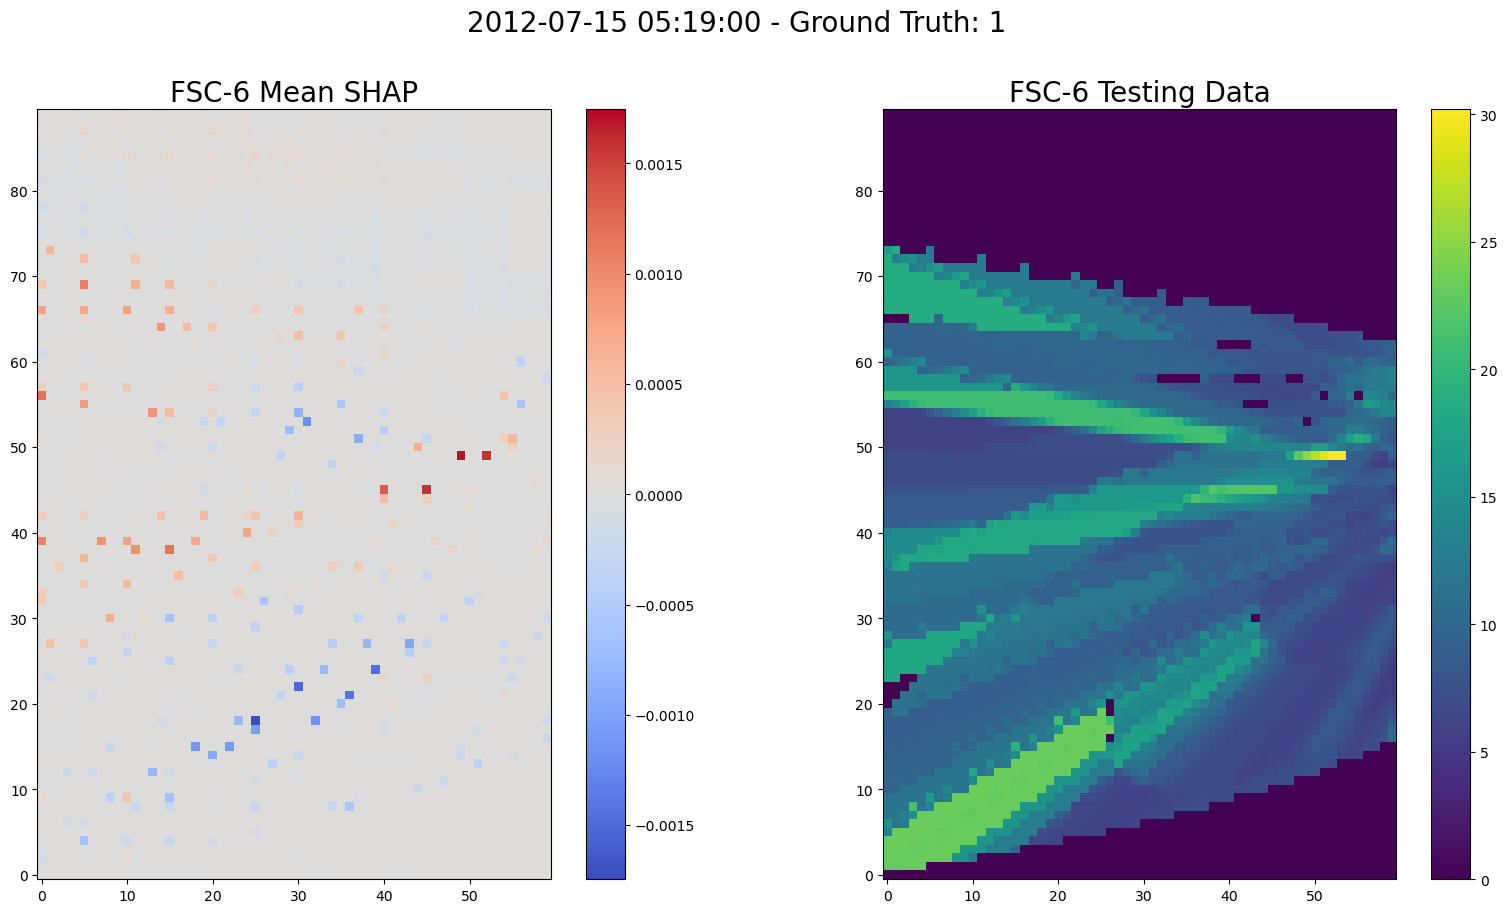

In [9]:
cluster = 'fennoscandinavian_cluster'
region = 'FSC-6'
# cluster = 'canadian_cluster'
# region = 'CAN-2'
positive_list = cluster_dict[cluster]['regions'][region]['twins_shap']['ytest'] == 1
# getting True indicies
positive_list = np.where(positive_list)[0]
print(positive_list)
j=955
i = positive_list[j]

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
# doing imshow with colorbar
plt.suptitle(f"{cluster_dict[cluster]['regions'][region]['twins_shap']['Date_UTC'].iloc[i][0]} - Ground Truth: {cluster_dict[cluster]['regions'][region]['twins_shap']['ytest'][i]}", fontsize=20)
extreme = np.max(np.abs(cluster_dict[cluster]['regions'][region]['twins_shap']['twins_mean_shap'][i]))
im = axes[0].imshow(cluster_dict[cluster]['regions'][region]['twins_shap']['twins_mean_shap'][i], cmap='coolwarm', vmin=-extreme, vmax=extreme, origin='lower')
fig.colorbar(im, ax=axes[0])
axes[0].set_title(f'{region} Mean SHAP', fontsize=20)

im = axes[1].imshow(cluster_dict[cluster]['regions'][region]['twins_shap']['testing_data'][1][i], origin='lower')
fig.colorbar(im, ax=axes[1])
axes[1].set_title(f'{region} Testing Data', fontsize=20)

plt.show()

In [18]:
cluster = 'fennoscandinavian_cluster'
region = 'FSC-4'
full, window = [], []
specific_mlt = 23
mlt_buff = 0.5
mlt_lower = specific_mlt - mlt_buff if specific_mlt >= mlt_buff else 24 - mlt_buff + specific_mlt
mlt_upper = specific_mlt + mlt_buff if specific_mlt <= (24-mlt_buff) else specific_mlt - 24 + mlt_buff
# if region in list_of_oversampled_regions:
# 	results = pd.read_feather(f'{results_dir}/twins_modeling_region_{region}_version_twins_v_maxpooling_oversampling.feather')
# else:
# 	results = pd.read_feather(f'{results_dir}/twins_modeling_region_{region}_version_twins_v_maxpooling.feather')
mlt_station = utils.loading_supermag(cluster_dict[cluster]['regions'][region]['mlt_station'])

plotting_df = pd.DataFrame()
for i in tqdm.tqdm(range(len(cluster_dict[cluster]['regions'][region]['twins_shap']['Date_UTC']))):
	mlt = mlt_station[mlt_station.index == cluster_dict[cluster]['regions'][region]['twins_shap']['Date_UTC'].iloc[i][0]]['MLT'].values[0]
	mlt_min = mlt-2 if mlt >=2 else 24+mlt-2
	mlt_max = mlt + 2 if mlt <= 22 else mlt-24+2

	if (mlt+mlt_buff) >= 24:
		if mlt <= mlt_lower and mlt >= mlt_upper:
			full_img_mean, full_selected_sections = mlt_wedge(cluster_dict[cluster]['regions'][region]['twins_shap']['twins_mean_shap'][i], mlt_min=mlt_min, mlt_max=mlt_max, center_x=70, center_y=45)
			window_img_mean, window_selected_sections = mlt_wedge(cluster_dict[cluster]['regions'][region]['twins_shap']['testing_data'][1][i], mlt_min=mlt_min, mlt_max=mlt_max, center_x=70, center_y=45)
			
			temp_df = pd.DataFrame({'full': full_selected_sections.flatten(), 'window': window_selected_sections.flatten(), 'ground_truth': cluster_dict[cluster]['regions'][region]['twins_shap']['ytest'][i]})
			plotting_df = pd.concat([plotting_df, temp_df], axis=0, ignore_index=True)
			
	else:
		if mlt >= mlt_lower and mlt <= mlt_upper:
			full_img_mean, full_selected_sections = mlt_wedge(cluster_dict[cluster]['regions'][region]['twins_shap']['twins_mean_shap'][i], mlt_min=mlt_min, mlt_max=mlt_max, center_x=70, center_y=45)
			window_img_mean, window_selected_sections = mlt_wedge(cluster_dict[cluster]['regions'][region]['twins_shap']['testing_data'][1][i], mlt_min=mlt_min, mlt_max=mlt_max, center_x=70, center_y=45)
			
			temp_df = pd.DataFrame({'full': full_selected_sections.flatten(), 'window': window_selected_sections.flatten(), 'ground_truth': cluster_dict[cluster]['regions'][region]['twins_shap']['ytest'][i]})
			plotting_df = pd.concat([plotting_df, temp_df], axis=0, ignore_index=True)

		
# plotting_df['full'] = full
# plotting_df['window'] = window
print(plotting_df)

plotting_df = plotting_df[abs(plotting_df['full'])>=0.0003]
pos_df = plotting_df[plotting_df['ground_truth'] == 1]
neg_df = plotting_df[plotting_df['ground_truth'] == 0]


fig, ax = plt.subplots(2, 2, figsize=(20, 10))
plt.suptitle(f'{region} MLT Centered on {specific_mlt} with +/- {mlt_buff} Buffer', fontsize=20)
ax[0,0].scatter(pos_df['window'], pos_df['full'])
ax[0,0].set_xlabel('Ion Temps')
ax[0,0].set_ylabel('SHAP Values')
ax[0,0].set_title('Positive')
ax[0,0].grid(True)

ax[1,0].scatter(neg_df['window'], neg_df['full'])
ax[1,0].set_xlabel('Ion Temps')
ax[1,0].set_ylabel('SHAP Values')
ax[1,0].set_title('Negative')
ax[1,0].grid(True)

ax[0,1].hist(pos_df['window'], bins=50, alpha=0.5, label='Positive', histtype='step', density=True)
ax[0,1].hist(neg_df['window'], bins=50, alpha=0.5, label='Negative', histtype='step', density=True)
ax[0,1].set_xlabel('Values')
ax[0,1].set_ylabel('Frequency')
ax[0,1].set_title('Ion Temps')
ax[0,1].legend()

ax[1,1].hist(pos_df['full'], bins=50, alpha=0.5, label='Positive', histtype='step', density=True)
ax[1,1].hist(neg_df['full'], bins=50, alpha=0.5, label='Negative', histtype='step', density=True)
ax[1,1].set_xlabel('Values')
ax[1,1].set_ylabel('Frequency')
ax[1,1].set_title('SHAP Values')
ax[1,1].legend()
plt.show()


Loading station ABK....


  0%|          | 0/16147 [00:00<?, ?it/s]/tmp/ipykernel_86554/3379399429.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mlt = mlt_station[mlt_station.index == cluster_dict[cluster]['regions'][region]['twins_shap']['Date_UTC'].iloc[i][0]]['MLT'].values[0]
  3%|▎         | 454/16147 [00:11<06:28, 40.43it/s]